In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import roc_auc_score,roc_curve
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz



#### Import data files

In [2]:
df=pd.read_csv('data/train.csv')
test_df=pd.read_csv('data/test.csv')
data_dict=pd.read_csv('data/data_dictionary.csv')

# ignore warnings
warnings.filterwarnings('ignore')

with_zero=df.loc[df.churn_probability<1]
with_one=df.loc[df.churn_probability>0]
ws=with_zero.sample(20000)
dfx=pd.concat([ws,with_one],axis=0).reset_index().drop(["index"], axis=1)

df=dfx
class_weights = {0: 0.1,
                1: 0.9}

#### Custom methods

In [3]:
class classificationModel:
    def __init__(self):
        self.train_accuracy=None
        self.train_precision=None
        self.train_recall=None
        self.train_f1_score=None
        self.train_auc_score=None
        self.test_accuracy=None
        self.test_precision=None
        self.test_recall=None
        self.test_f1_score=None
        self.test_auc_score=None
def splitcategories(df):
    nums=df._get_numeric_data().columns
    cats=list(set(df.columns)-set(nums))
    return nums,cats

def filterColsbyNA(df,num):
    df.shape
    temp=pd.DataFrame(df.isna().sum()).reset_index()
    temp=temp.set_axis(['name','nullcount'],axis=1)
    temp['ratio']=temp.nullcount/df.shape[0]*100
    return temp.loc[temp.ratio>num].name.to_list()

def getsmallercols(df,limit):
    nums=df._get_numeric_data().columns.to_list()
    a=[]
    for col in nums:
        if df[col].value_counts().count() < limit:
            a.append(col)
    return a
def addBinnedCols(df,cols,binSize):
    y=list(map(lambda x:x/binSize ,list(range(1,binSize+1)))) 
    for col in cols:
        a=df[col].quantile(y).to_list()
        df[str(col)+'_binned']=df[col].apply(lambda x:getVal(a,x))
    return df
def get_dt_graph(dt_classifier,X):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=X.columns, 
                    class_names=['No Churn', "Churn"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph
def evaluate_model(dt_classifier,X_train,X_test,y_train,y_test):
    cm=classificationModel()
    ##################################################################
    train_predictions=dt_classifier.predict(X_train)
    cm_train=confusion_matrix(y_train, train_predictions)
    TN_train,FP_train,FN_train,TP_train=cm_train.ravel()
    Precision_train=(TP_train) / (TP_train+FP_train)
    Recall_train = (TP_train) / (TP_train+FN_train)
    F1_score_train=2*(Precision_train*Recall_train)/(Precision_train+Recall_train)
    cm.train_accuracy=accuracy_score(y_train,train_predictions)
    cm.train_auc_score=roc_auc_score(y_train,train_predictions)
    cm.train_precision=Precision_train
    cm.train_recall=Recall_train
    cm.train_f1_score=F1_score_train
    ##################################################################
    
    ##################################################################
    test_predictions=dt_classifier.predict(X_test)
    cm_test=confusion_matrix(y_test, test_predictions)
    TN_test,FP_test,FN_test,TP_test=cm_test.ravel()
    Precision_test=(TP_test) / (TP_test+FP_test)
    Recall_test = (TP_test) / (TP_test+FN_test)
    F1_score_test=2*(Precision_test*Recall_test)/(Precision_test+Recall_test)
    cm.test_accuracy=accuracy_score(y_test,test_predictions)
    cm.test_auc_score=roc_auc_score(y_test,test_predictions)
    cm.test_precision=Precision_test
    cm.test_recall=Recall_test
    cm.test_f1_score=F1_score_test
    ##################################################################
    print("="*50+"Training data"+"="*50)
    print("Train Accuracy :%f"%cm.train_accuracy)
    print("Train Confusion Matrix:")
    print(cm_train)
    print("Precision->%f"%cm.train_precision)
    print("Recall->%f"%cm.train_recall)
    print("F1_score->%f"%cm.train_f1_score)
    fpr,tpr,_=roc_curve(y_train,train_predictions)
    plt.plot(fpr,tpr,label="AUC score %f"%cm.train_auc_score)
    plt.legend()
    plt.show()
    print("-"*113)
    print("="*52+"Test data"+"="*52)
    print("Test Accuracy :%f"%cm.test_accuracy )
    print("Test Confusion Matrix:")
    print(cm_test)
    print("Precision->%f"%cm.test_precision)
    print("Recall->%f"%cm.test_recall)
    print("F1_score->%f"%cm.test_f1_score)
    fpr,tpr,_=roc_curve(y_test,test_predictions)
    plt.plot(fpr,tpr,label="AUC score %f"%cm.test_auc_score)
    plt.legend()
    plt.show()
    return cm

In [4]:
global performance_grid
performance_grid={}

#### Data cleaning

In [5]:
nums,cats = splitcategories(df)
print("Total number of categorical variables: %d"%len(cats))
[print('=> '+x) for x in cats]

# Ignoring date of recharge as not adding value to total data set, hence dropping

df.drop(columns=cats,inplace=True)
df.shape

Total number of categorical variables: 9
=> last_date_of_month_7
=> date_of_last_rech_data_6
=> last_date_of_month_8
=> last_date_of_month_6
=> date_of_last_rech_6
=> date_of_last_rech_data_7
=> date_of_last_rech_8
=> date_of_last_rech_7
=> date_of_last_rech_data_8


(27132, 163)

#### Exploratory data analysis

In [6]:
# Checking NA fields

# Visualizing columns with Null values between 1% and 10% of total data set
print("*"*110)
print(list(set(filterColsbyNA(df,1))-set(filterColsbyNA(df,10))))
print("*"*110)
# As most of the values are for mou which represents minutes of usage , we can safely impute by 0 in case of NaN

print("*"*110)
print(filterColsbyNA(df,10))
print("*"*110)

# Even columns with more than 10% of NaN is mostly of recharge 
# so an empty recharge is technically a zero amount recharge

**************************************************************************************************************
['ic_others_7', 'std_ic_t2f_mou_7', 'roam_og_mou_6', 'spl_ic_mou_6', 'loc_og_t2t_mou_6', 'std_ic_t2f_mou_6', 'loc_og_t2m_mou_7', 'loc_ic_t2m_mou_6', 'roam_og_mou_7', 'og_others_6', 'spl_ic_mou_7', 'roam_ic_mou_6', 'loc_ic_mou_6', 'std_og_t2t_mou_7', 'loc_og_mou_7', 'loc_og_t2f_mou_6', 'std_og_t2f_mou_7', 'offnet_mou_6', 'std_og_t2f_mou_6', 'std_ic_t2t_mou_6', 'std_ic_mou_7', 'loc_og_t2o_mou', 'std_ic_t2t_mou_7', 'std_og_t2o_mou', 'std_ic_mou_6', 'loc_og_t2c_mou_7', 'std_og_t2t_mou_6', 'isd_og_mou_6', 'std_ic_t2m_mou_6', 'loc_ic_t2t_mou_6', 'spl_og_mou_6', 'isd_og_mou_7', 'isd_ic_mou_6', 'onnet_mou_6', 'loc_og_t2f_mou_7', 'isd_ic_mou_7', 'std_og_t2m_mou_7', 'std_ic_t2o_mou_7', 'onnet_mou_7', 'loc_og_mou_6', 'std_og_t2m_mou_6', 'offnet_mou_7', 'loc_ic_t2t_mou_7', 'loc_og_t2m_mou_6', 'loc_og_t2t_mou_7', 'loc_ic_t2f_mou_7', 'std_ic_t2o_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_6

#### Based on NaN analysis above, we would be imputing NaN for whole dataframe

In [7]:
df_imputed=df.fillna(0)
df_test_imputed=test_df.fillna(0)


In [8]:
# columns with zero std deviation
temp=df_imputed.describe().transpose().reset_index().rename(columns={'index':'name'})
cols_to_remove=temp.loc[(temp['std']==0)].name.to_list()
cols_to_remove.append('id')




In [9]:
df_imputed.drop(columns=cols_to_remove,inplace=True,errors='ignore')
df_test_imputed.drop(columns=cats,inplace=True)
df_test_imputed.drop(columns=cols_to_remove,inplace=True,errors='ignore')


In [10]:
X=df_imputed[set(df_imputed.columns)-set(['churn_probability'])]
y=df_imputed.churn_probability

X_test_final=df_test_imputed


print("Original dataset shape->"+str(X.shape))
print("Test Final dataset shape->"+str(X_test_final.shape))


Original dataset shape->(27132, 151)
Test Final dataset shape->(30000, 151)


In [11]:
%%time
plt.figure(figsize=[15,15])
corr=X.corr()
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

CPU times: user 8min 29s, sys: 38 s, total: 9min 7s
Wall time: 1min 9s


feature           VIF
0           sachet_2g_6           inf
1        total_og_mou_8  9.766442e+09
2        total_ic_mou_8  3.475857e+09
3           vol_3g_mb_6  4.710580e+00
4           sachet_3g_6           inf
..                  ...           ...
146    loc_ic_t2f_mou_6  4.049595e+07
147    std_og_t2m_mou_8  5.143191e+09
148         ic_others_8  6.265365e+06
149  last_day_rch_amt_6  2.985088e+00
150         og_others_7  1.108952e+04

[151 rows x 2 columns]

<Figure size 1080x1080 with 0 Axes>

<AxesSubplot:>

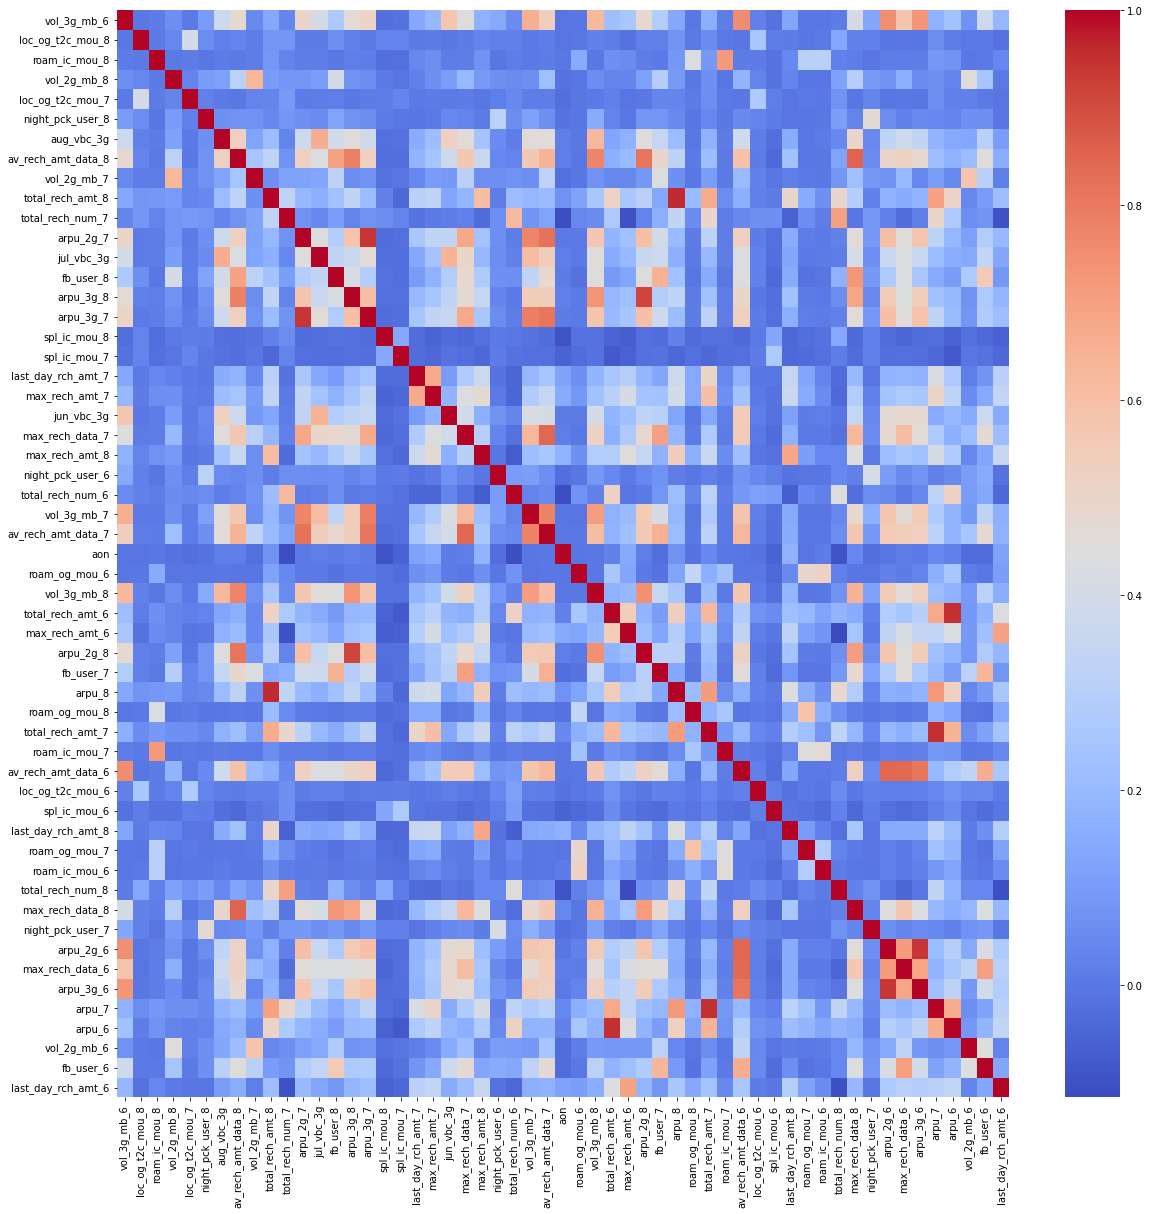

In [12]:
vifs=vif_data.loc[vif_data['VIF']<1000].feature.to_list()
plt.figure(figsize=[20,20])
sns.heatmap(X[vifs].corr(),cmap='coolwarm')

In [13]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,random_state=42)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled=pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_scaled=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)
X_test_final_scaled=pd.DataFrame(scaler.transform(X_test_final),columns=X_test_final.columns)

## RFE

In [15]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe=RFE(logreg,n_features_to_select=30)

In [16]:
rfe.fit(X_train_scaled,y_train)
import statsmodels.api as sm

In [17]:
col = X_train.columns[rfe.support_]
X_train_scaled_rfe=X_train_scaled[col]
X_test_scaled_rfe=X_test_scaled[col]
X_test_final_scaled_rfe=X_test_final_scaled[col]

In [18]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=4,class_weight=class_weights)

dt.fit(X_train_scaled_rfe, y_train)

DecisionTreeClassifier(class_weight={0: 0.1, 1: 0.9}, max_depth=4)

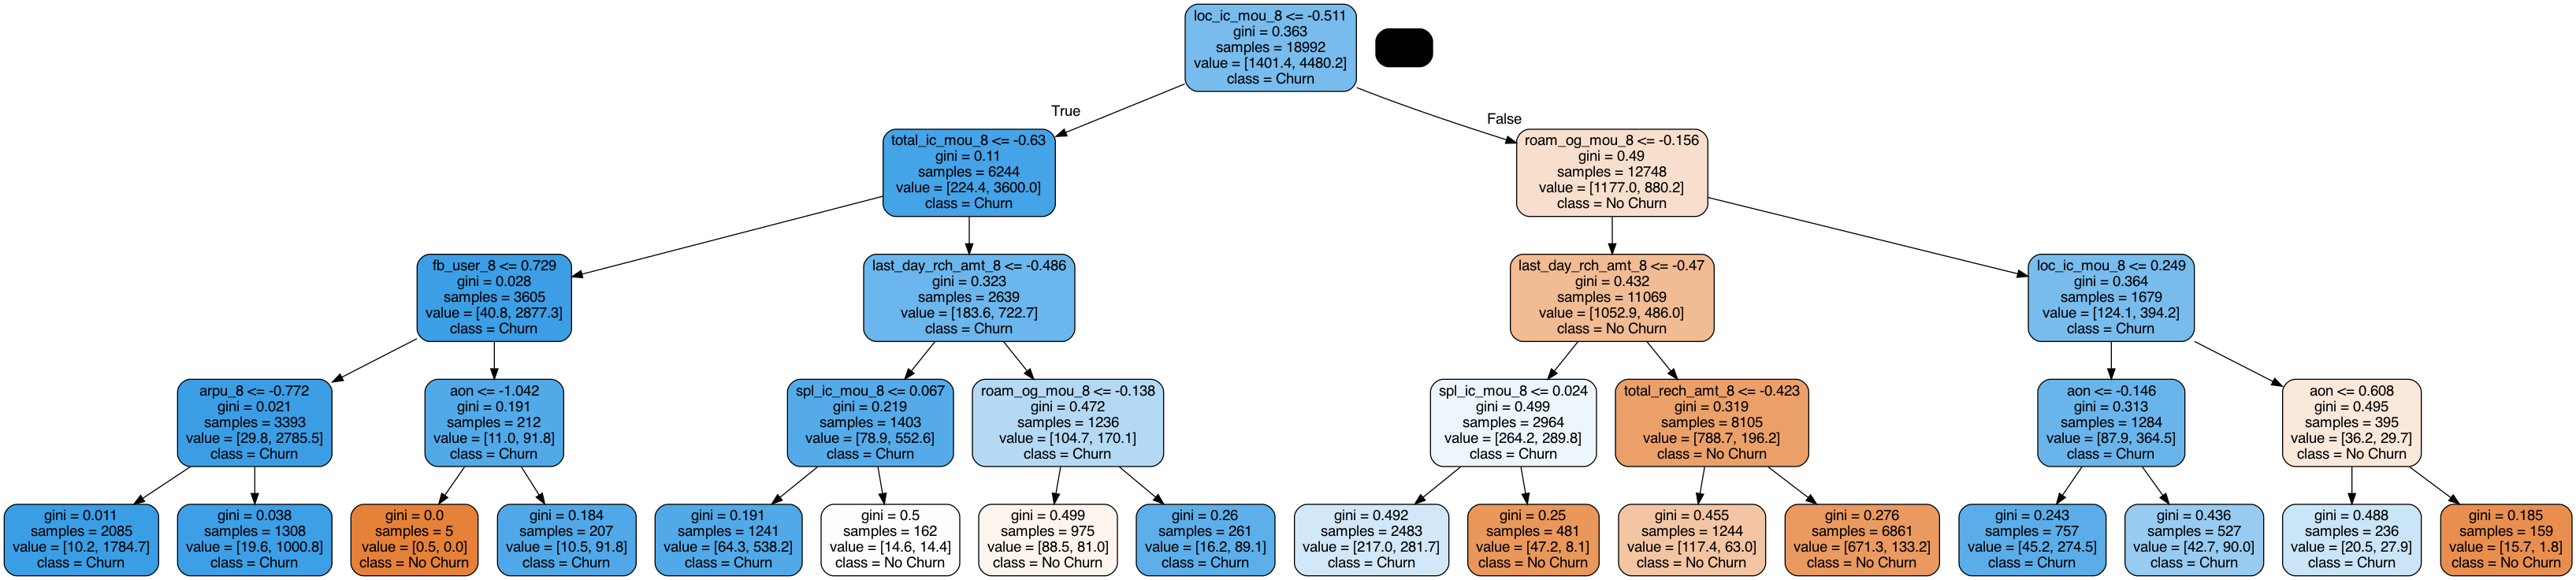

In [19]:
gph=get_dt_graph(dt,X_train_scaled_rfe)
Image(gph.create_png())

In [20]:
y_train_pred = dt.predict(X_train_scaled_rfe)
y_test_pred = dt.predict(X_test_scaled_rfe)

In [21]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score

print(accuracy_score(y_train, y_train_pred))
cm=confusion_matrix(y_train, y_train_pred)

0.7474199663016007


### Evaluation of model

==================================================Training data==================================================
Train Accuracy :0.747420
Train Confusion Matrix:
[[9552 4462]
 [ 335 4643]]
Precision->0.509940
Recall->0.932704
F1_score->0.659377


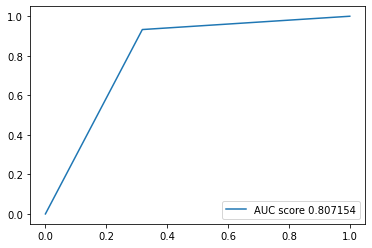

-----------------------------------------------------------------------------------------------------------------
====================================================Test data====================================================
Test Accuracy :0.741523
Test Confusion Matrix:
[[4063 1923]
 [ 181 1973]]
Precision->0.506417
Recall->0.915970
F1_score->0.652231


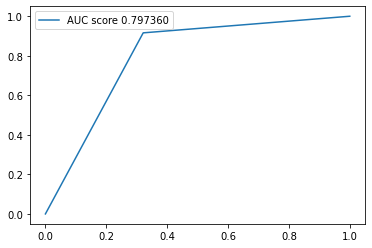

In [22]:
cms=evaluate_model(dt,X_train_scaled_rfe,X_test_scaled_rfe,y_train,y_test)
performance_grid['Decision_tree']=cms.__dict__

### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, min_samples_leaf=5,class_weight=class_weights)
rf.fit(X_train_scaled_rfe, y_train)

RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_depth=5,
                       min_samples_leaf=5, n_jobs=-1, random_state=42)

In [24]:
sample_tree = rf.estimators_[30]

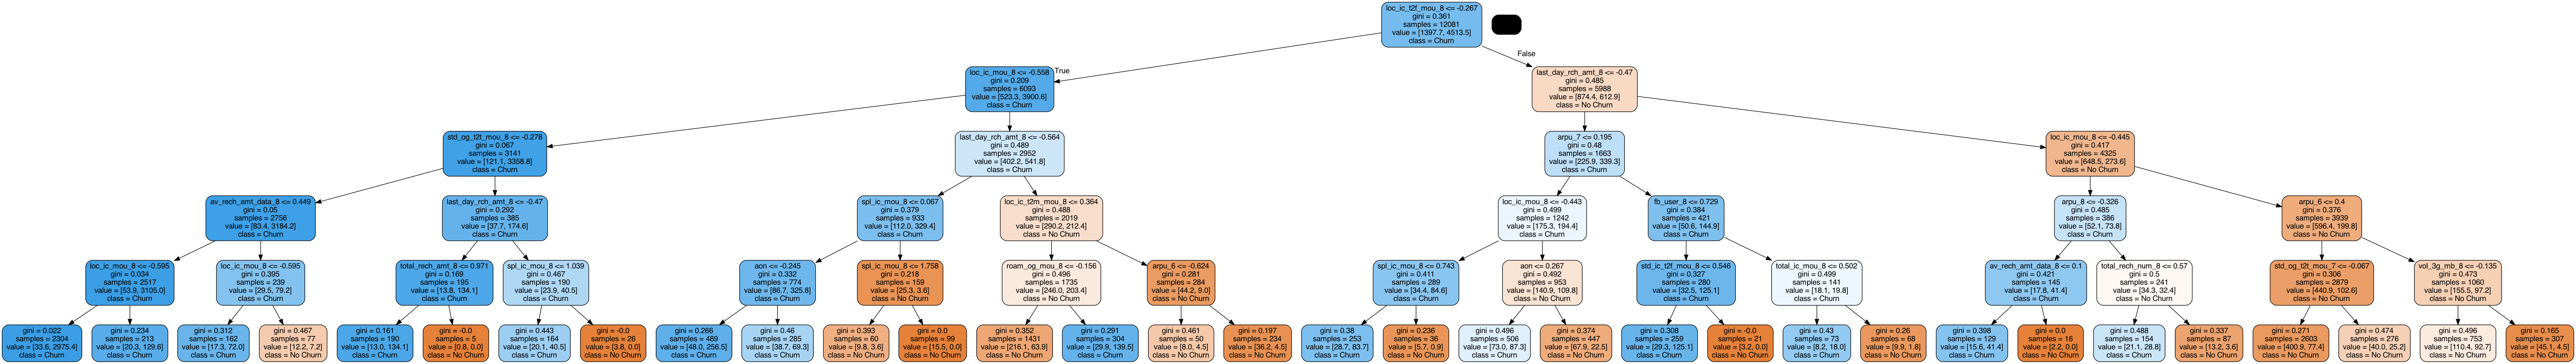

In [25]:
graph=get_dt_graph(sample_tree,X_train_scaled_rfe)
Image(graph.create_png())

In [26]:
y_train_pred = rf.predict(X_train_scaled_rfe)
y_test_pred = rf.predict(X_test_scaled_rfe)

==================================================Training data==================================================
Train Accuracy :0.802706
Train Confusion Matrix:
[[10591  3423]
 [  324  4654]]
Precision->0.576204
Recall->0.934914
F1_score->0.712984


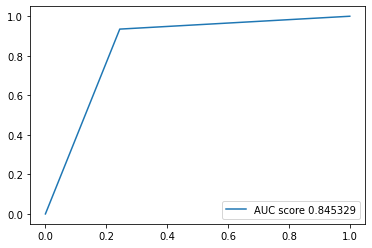

-----------------------------------------------------------------------------------------------------------------
====================================================Test data====================================================
Test Accuracy :0.786364
Test Confusion Matrix:
[[4447 1539]
 [ 200 1954]]
Precision->0.559405
Recall->0.907149
F1_score->0.692049


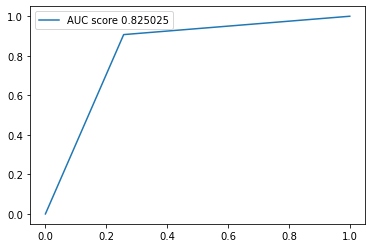

In [27]:
cms=evaluate_model(rf,X_train_scaled_rfe,X_test_scaled_rfe,y_train,y_test)
performance_grid['Random Forest']=cms.__dict__

#### Grid search for hyper parameter tuning

In [28]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
from sklearn.model_selection import GridSearchCV

In [29]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [3, 5,8],
    'min_samples_leaf': [10, 20],
    'max_features': [20,30],
    'n_estimators': [50,80]
}

In [30]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")


In [31]:
%%time
grid_search.fit(X_train_scaled_rfe,y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
CPU times: user 11.8 s, sys: 280 ms, total: 12.1 s
Wall time: 42.6 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 8], 'max_features': [20, 30],
                         'min_samples_leaf': [10, 20],
                         'n_estimators': [50, 80]},
             scoring='accuracy', verbose=1)

In [32]:
rf_best = grid_search.best_estimator_

In [33]:
rf_best

RandomForestClassifier(max_depth=8, max_features=20, min_samples_leaf=10,
                       n_estimators=80, n_jobs=-1, random_state=42)

==================================================Training data==================================================
Train Accuracy :0.912700
Train Confusion Matrix:
[[13553   461]
 [ 1197  3781]]
Precision->0.891325
Recall->0.759542
F1_score->0.820174


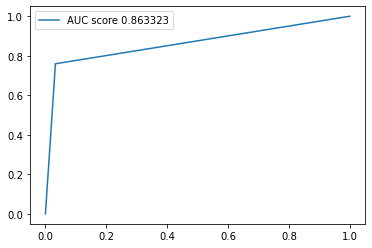

-----------------------------------------------------------------------------------------------------------------
====================================================Test data====================================================
Test Accuracy :0.894840
Test Confusion Matrix:
[[5726  260]
 [ 596 1558]]
Precision->0.856986
Recall->0.723305
F1_score->0.784491


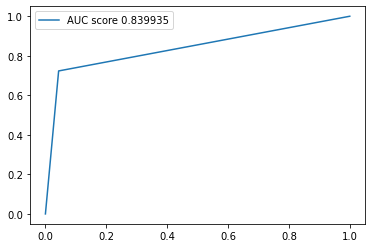

In [34]:
y_train_pred = rf.predict(X_train_scaled_rfe)
y_test_pred = rf.predict(X_test_scaled_rfe)

cms=evaluate_model(rf_best,X_train_scaled_rfe,X_test_scaled_rfe,y_train,y_test)
performance_grid['Random Forest CV']=cms.__dict__

In [35]:
sample_tree = rf_best.estimators_[20]

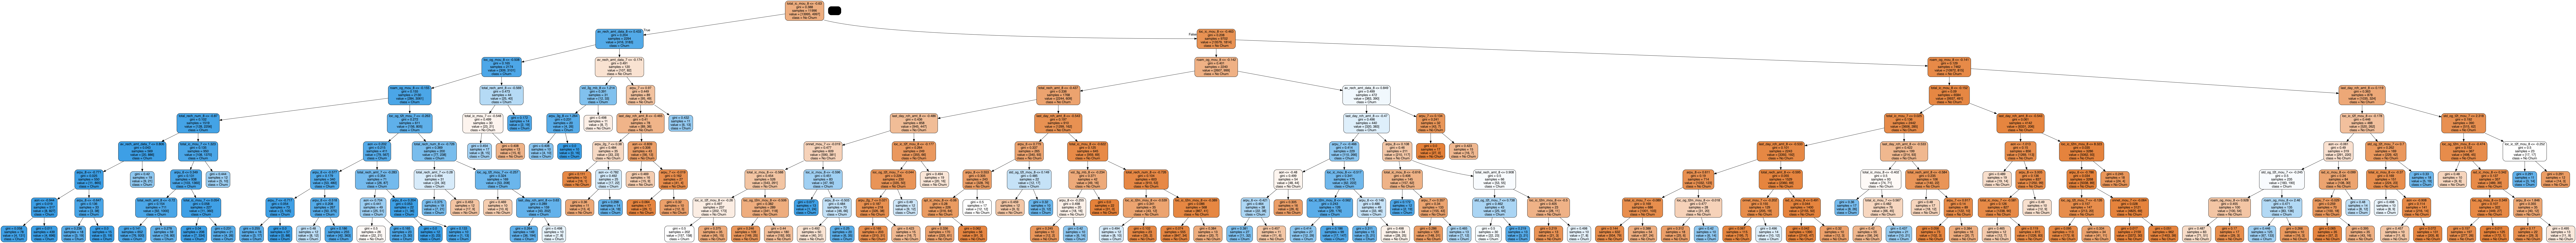

In [36]:
gph = get_dt_graph(sample_tree,X_train_scaled_rfe)
Image(gph.create_png())

### XGBOOST

In [37]:
import xgboost as xgb
#xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',eval_metric='mlogloss')

xgb_cfl = xgb.XGBClassifier(subsample=0.5, n_estimators=20, min_child_weight=3, max_depth=3, learning_rate=0.01, gamma=0.5,colsample_bytree=0.5,eval_metric='mlogloss')





In [38]:
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.5,
 'enable_categorical': False,
 'gamma': 0.5,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_delta_step': None,
 'max_depth': 3,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 20,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eval_metric': 'mlogloss'}

In [39]:
# Fit the model to our train and target
xgb_cfl.fit(X_train_scaled_rfe, y_train)  # default 
# Get our predictions
xgb_predictions = xgb_cfl.predict(X_test_scaled_rfe)
xgb_predictions

array([1, 0, 0, ..., 1, 0, 0])

In [40]:
xgb_predictions_prob = xgb_cfl.predict_proba(X_test_scaled_rfe)
xgb_predictions_prob

array([[0.4338339 , 0.5661661 ],
       [0.5701653 , 0.42983472],
       [0.58233154, 0.41766843],
       ...,
       [0.42430836, 0.57569164],
       [0.58233154, 0.41766843],
       [0.5817274 , 0.4182726 ]], dtype=float32)

In [41]:
accuracy_score(y_test, xgb_predictions)

0.8769041769041769

In [42]:
confusion_matrix(y_test, xgb_predictions)

array([[5781,  205],
       [ 797, 1357]])

==================================================Training data==================================================
Train Accuracy :0.888216
Train Confusion Matrix:
[[13626   388]
 [ 1735  3243]]
Precision->0.893142
Recall->0.651466
F1_score->0.753398


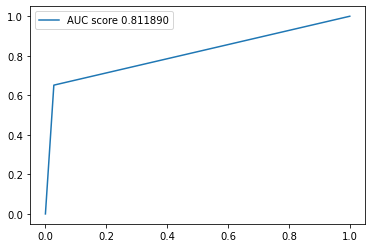

-----------------------------------------------------------------------------------------------------------------
====================================================Test data====================================================
Test Accuracy :0.876904
Test Confusion Matrix:
[[5781  205]
 [ 797 1357]]
Precision->0.868758
Recall->0.629991
F1_score->0.730355


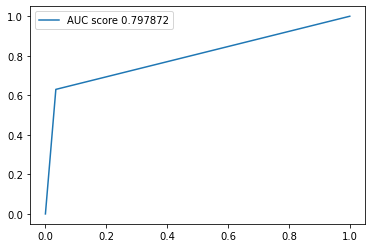

In [43]:
cms=evaluate_model(xgb_cfl,X_train_scaled_rfe,X_test_scaled_rfe,y_train,y_test)
performance_grid['XG Boost']=cms.__dict__

In [44]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve
# A parameter grid for XGBoost
# params = {
#         'n_estimators' : [100, 200, 500, 750], # no of trees 
#         'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
#         'min_child_weight': [1, 5, 7, 10],
#         'gamma': [0.1, 0.5, 1, 1.5, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5, 10, 12]
#         }

params = {
        'n_estimators' : [100,200], # no of trees 
        'learning_rate' : [0.001,0.005],  # eta
        'min_child_weight': [10],
        'gamma': [0.6,0.9],
        'subsample': [0.6,0.8],
        'colsample_bytree': [0.6],
        'max_depth': [5, 10]
        }
folds = 5

param_comb = 800
random_search = RandomizedSearchCV(xgb_cfl, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3, random_state=42)



In [ ]:
%%time
random_search.fit(X_train_scaled_rfe,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [ ]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best accuracy for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ )
print('\n Best hyperparameters:')
print(random_search.best_params_)

In [ ]:
cms=evaluate_model(random_search,X_train_scaled_rfe,X_test_scaled_rfe,y_train,y_test)
performance_grid['XG Bosst Random_search']=cms.__dict__

In [ ]:
%%time

In [ ]:
pg=pd.DataFrame(performance_grid).transpose()
#Comparison
pg

### Prediction on Final submission

In [ ]:
y_test_final=rf.predict(X_test_final_scaled_rfe)

In [ ]:
output=pd.DataFrame()
output['id']=test_df.id
output['churn_probability']=y_test_final

In [ ]:
output.churn_probability.value_counts()

In [ ]:
output.to_csv('output_traditional.csv',index=False)

In [ ]:
##### Trying to reduce class imbalance

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy=0.5)
smn=SMOTEENN()
ads=ADASYN(random_state=42)
X_train_scaled_rfe_sm,y_train_sm=oversample.fit_resample(X_train_scaled_rfe,y_train)
y_train_sm.value_counts()

In [ ]:
y_train.value_counts()

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

history = model.fit(X_train_scaled_rfe, y_train, epochs=500)

In [ ]:

predictions=model.predict(X_test_scaled_rfe)
prediction_classes = [
    1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
]
print(f'Accuracy: {accuracy_score(y_test, prediction_classes):.2f}')
print(f'Precision: {precision_score(y_test, prediction_classes):.2f}')
print(f'Recall: {recall_score(y_test, prediction_classes):.2f}')

In [ ]:
y_test_final_temp=model.predict(X_test_final_scaled_rfe)
y_test_final = [
    1 if prob > 0.5 else 0 for prob in np.ravel(y_test_final_temp)
]
output=pd.DataFrame()
output['id']=test_df.id
output['churn_probability']=y_test_final
output.churn_probability.value_counts()

In [ ]:
output.to_csv('output_DeepLearning.csv',index=False)